In [1]:
import os
os.chdir('../') # change directory to import our modules

In [2]:
import os

import nd2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import pandas as pd
from tqdm import tqdm
from ipywidgets import interactive

from data import config 
from data.data import Data
from misc.satellite_cleaning import clean_sattelites

In [3]:
data = Data()

LABEL_MAP = ['empty/overcrowded', 'all dead', 'all alive', '50/50']

In [4]:
data.droplet_list[0]

{'sample_idx': 0, 'x': 2826, 'y': 69, 'r': 66}

# Create sample images without satellites

In [17]:
if not os.path.exists(f'{config.ROOT_PATH}/data/clean_samples'):
    os.mkdir(f'{config.ROOT_PATH}/data/clean_samples')

for idx, sample in tqdm(enumerate(data.sample_list)):
    sample_img = nd2.imread(sample['img_path'])[-1]
    clean_sample_img = clean_sattelites(sample_img, verbose=False)
    np.save(f'{config.ROOT_PATH}/data/clean_samples/clean_img{idx}.npy', clean_sample_img)

100%|██████████| 115/115 [00:00<00:00, 10354.75it/s]
41it [3:39:22, 321.05s/it]


# Try to make a new label algorithm

In [33]:
def get_img_and_label(idx):
    droplet = data.droplet_list[idx]
    sample_img = np.load(f'{config.ROOT_PATH}/data/clean_samples/clean_img{droplet["sample_idx"]}.npy')
    x = droplet['x']; y = droplet['y']; r = droplet['r']
    img_bf = sample_img[x-r:x+r, y-r:y+r]  ## bf
    # change zeros to max number to invert satellite masks
    img_bf[img_bf == 0] = np.max(img_bf)

    img = np.load(f'{config.ROOT_PATH}/data/clean/img{idx}.npy')
    img[-1, ...] = img_bf

    img = resize(img, (img.shape[0], config.IMG_SIZE[0], config.IMG_SIZE[1]), anti_aliasing=True, preserve_range=True)
    label = data[idx][1].item()
    return img, label

x_coor = np.linspace(0, config.IMG_SIZE[0], config.IMG_SIZE[1])
y_coor = np.linspace(0, config.IMG_SIZE[0], config.IMG_SIZE[1])
X_coor, Y_coor = np.meshgrid(x_coor, y_coor)

STD = 9.161341223180239
Range = 69.52598002488548


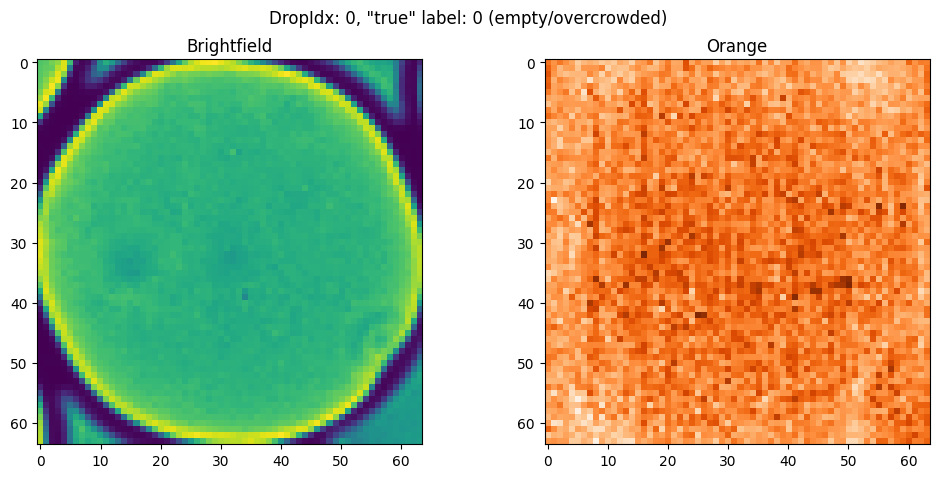

In [130]:
idx = 0
# 1 3 7 8 9
bf_channel = 3
orng_channel = 2


img, label = get_img_and_label(idx)
bf = img[bf_channel, ...]
# mirror by x-axis to check validity of the method
# bf = bf[::-1, :]
orng = img[orng_channel, ...]

print('STD =', np.std(orng.flatten()))
orng_range = np.max(orng.flatten()) - np.min(orng.flatten())
print('Range =', orng_range)


fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax[0].imshow(bf)
ax[0].set_title('Brightfield')
ax[1].imshow(orng, cmap='Oranges')
ax[1].set_title('Orange')
None

In [131]:
def create_circle_mask(img_size, beta):
    mask = np.zeros(img_size)
    center = (img_size[0] // 2, img_size[1] // 2)
    radius = int(beta * np.min(img_size) / 2)

    for i in range(img_size[0]):
        for j in range(img_size[1]):
            l2 = (i - center[0])**2 + (j - center[1])**2
            mask[i, j] = 1*(l2 <= radius**2)
    return mask

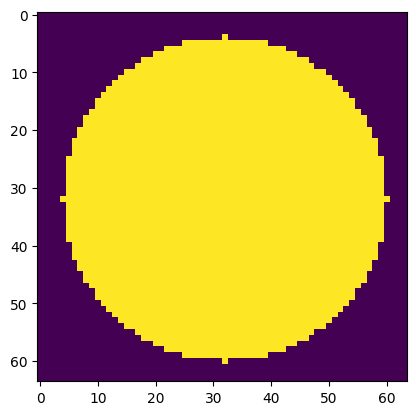

In [132]:
# look at only the 0.9*64 circle
mask = create_circle_mask(config.IMG_SIZE, 0.9)
plt.imshow(mask);

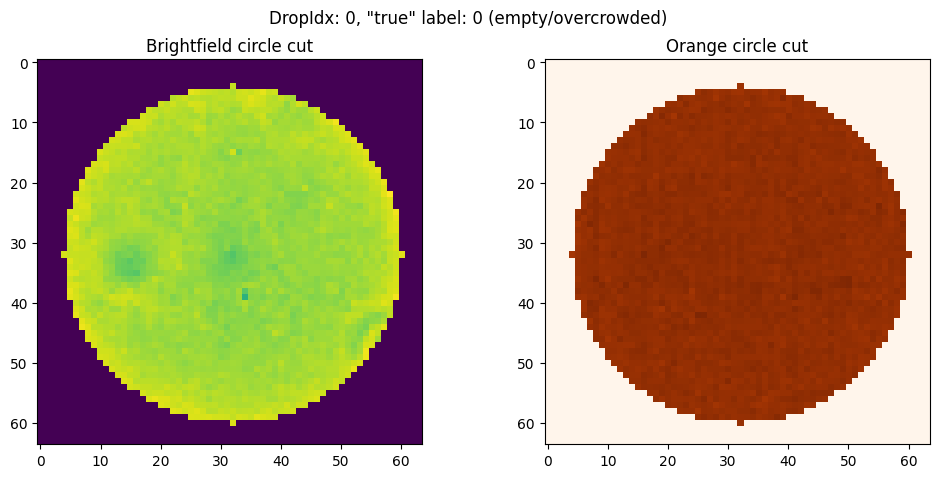

In [133]:
bf_circle = bf * mask
orng_circle = orng * mask

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax[0].imshow(bf_circle)
ax[0].set_title('Brightfield circle cut')
ax[1].imshow(orng_circle, cmap='Oranges')
ax[1].set_title('Orange circle cut')
None

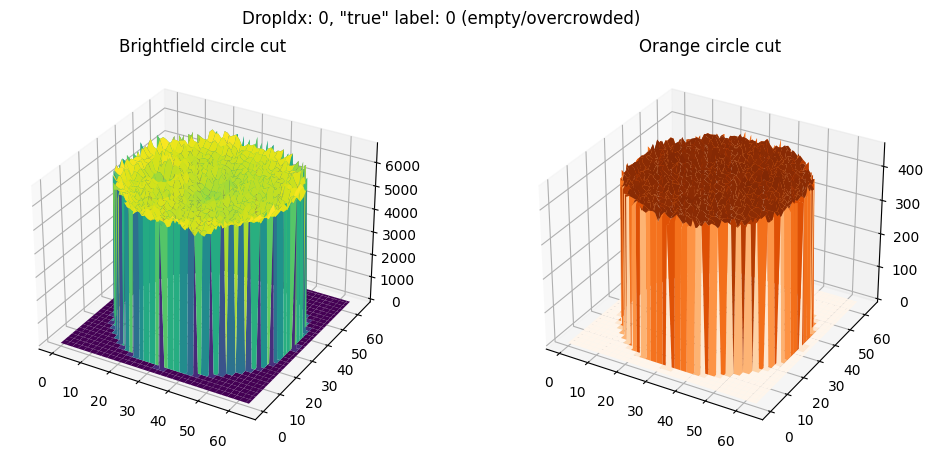

In [134]:
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax0.plot_surface(X_coor, Y_coor, bf_circle, cmap='viridis')
ax0.set_title('Brightfield circle cut')
ax1.plot_surface(X_coor, Y_coor, orng_circle, cmap='Oranges')
ax1.set_title('Orange circle cut')
None

In [135]:
def min_max_norm(x, min=None, max=None, clip=True):
    if min is None:
        min = np.min(x)
    if max is None:
        max = np.max(x)
    x_norm = (x - min) / (max - min)
    if clip:
        x_norm = np.clip(x_norm, 0, 1)
    return x_norm

there is no orange peaks in the image


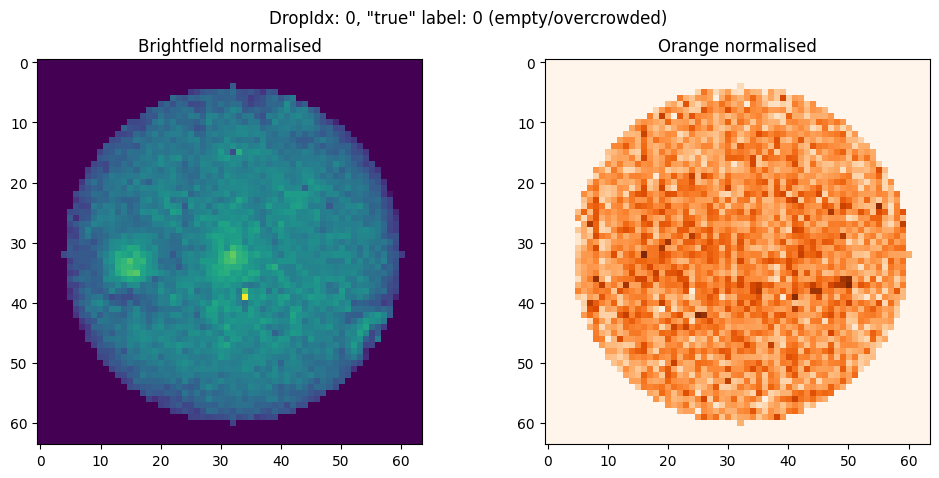

In [136]:
mask_bool = mask.astype(bool)

sample_idx = data.droplet_list[idx]['sample_idx']
norm_min = data.sample_list[sample_idx]['stats'][bf_channel]['min']
norm_max = data.sample_list[sample_idx]['stats'][bf_channel]['percentile']
bf_norm = bf_circle
bf_norm[mask_bool] = -min_max_norm(bf_circle[mask_bool], norm_min, norm_max)+1 # reverse pixels

orng_norm = orng_circle
orng_norm[mask_bool] = min_max_norm(orng_circle[mask_bool])
if orng_range < 100: # if there is no peak
    print('there is no orange peaks in the image')
    orng_norm = orng_norm * 0.1

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax[0].imshow(bf_norm)
ax[0].set_title('Brightfield normalised')
ax[1].imshow(orng_norm, cmap='Oranges')
ax[1].set_title('Orange normalised')
None

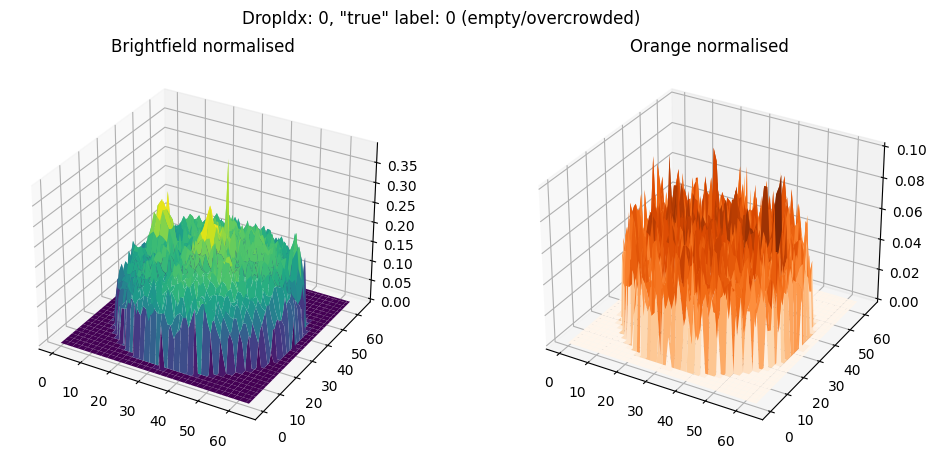

In [137]:
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]})')
ax0.plot_surface(X_coor, Y_coor, bf_norm, cmap='viridis')
ax0.set_title('Brightfield normalised')
ax1.plot_surface(X_coor, Y_coor, orng_norm, cmap='Oranges')
ax1.set_title('Orange normalised')
None

In [138]:
h = np.minimum(orng_norm, bf_norm)
alpha = 0.3
h_a = 1*(h>=alpha)

bf_norm_a = 1*(bf_norm >= alpha)

res = -1
if np.sum(bf_norm_a) != 0:  # if sum(bf_norm_a) == 0, cells are almost non-recognisable, so output -1
    res = np.sum(h_a) / np.sum(bf_norm_a)
res

0.0

In [141]:
def interactive_cut(val, axis, alpha):
    global bf_norm_circle, orng_norm_circle

    xx = np.arange(64)
    if axis == 0:
        f = bf_norm_circle[val, :]
        g = orng_norm_circle[val, :]
    elif axis == 1:
        f = bf_norm_circle[:, val]
        g = orng_norm_circle[:, val]

    plt.bar(xx, f, color='blue', label='BF Norm', alpha=0.6)
    plt.bar(xx, g, color='orange', label='Orange', alpha=0.6)
    h = np.minimum(f, g)
    plt.plot(xx, h, color='red', label='h function', alpha=0.6)
    h_a = h >= alpha
    plt.axhline(alpha, color='black', label=f'alpha = {alpha}', alpha=0.6)
    plt.scatter(xx[h_a], h[h_a], color='green', label='h_a superlevel', alpha=0.6)
    plt.legend()
    plt.ylim((0, 1))
    plt.show()

In [142]:
interactive_plot = interactive(interactive_cut, val=(0, 63, 1), axis=[0,1], alpha=(0, 1, 0.05))
interactive_plot

interactive(children=(IntSlider(value=31, description='val', max=63), Dropdown(description='axis', options=(0,…

# Compute new labels and show a distribution

In [120]:
ALPHA = 0.3
BETA = 0.9
MIN_ORNG_RANGE = 100

In [117]:
def get_new_label(img, idx, data, mask, alpha, min_orng_range):
    bf_channel = img.shape[0]-1
    orng_channel = img.shape[0]-2

    # extract channels
    bf = img[bf_channel, ...]
    orng = img[orng_channel, ...]

    orng_range = np.max(orng.flatten()) - np.min(orng.flatten())
    
    # cut the circle
    bf_circle = bf * mask
    orng_circle = orng * mask

    # normalise
    mask_bool = mask.astype(bool)

    sample_idx = data.droplet_list[idx]['sample_idx']
    norm_min = data.sample_list[sample_idx]['stats'][bf_channel]['min']
    norm_max = data.sample_list[sample_idx]['stats'][bf_channel]['percentile']
    bf_norm = bf_circle
    bf_norm[mask_bool] = -min_max_norm(bf_circle[mask_bool], norm_min, norm_max)+1 # reverse pixels
    orng_norm = orng_circle
    orng_norm[mask_bool] = min_max_norm(orng_circle[mask_bool])

    if orng_range < min_orng_range:  # there is no peak in orange
        orng_norm = orng_norm * 0.1
    

    # compute new label
    h = np.minimum(orng_norm, bf_norm)
    h_a = 1*(h >= alpha)
    bf_norm_a = 1*(bf_norm >= alpha)

    if np.sum(bf_norm_a) == 0:  # if sum(bf_norm_a) == 0, cells are almost non-recognisable, so output -1
        return -1

    return np.sum(h_a) / np.sum(bf_norm_a)

In [118]:
data = Data()
mask = create_circle_mask(config.IMG_SIZE, BETA)

Range = 69.52598002488548


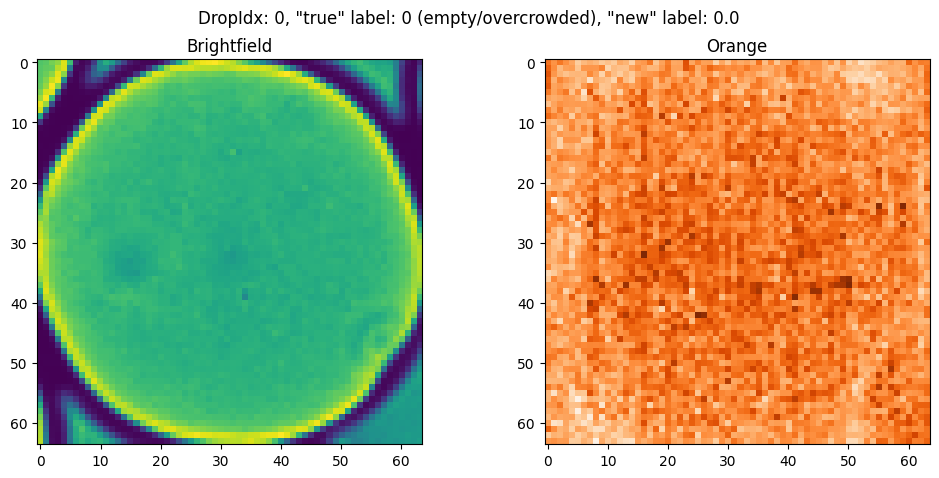

In [129]:
idx = 0

img, label = get_img_and_label(idx)
new_label = get_new_label(img, idx, data, mask, ALPHA, MIN_ORNG_RANGE)


# visualise
bf_channel = img.shape[0]-1
orng_channel = img.shape[0]-2
# extract channels
bf = img[bf_channel, ...]
orng = img[orng_channel, ...]

orng_range = np.max(orng.flatten()) - np.min(orng.flatten())
print('Range =', orng_range)
# plot
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'DropIdx: {idx}, "true" label: {label} ({LABEL_MAP[label]}), "new" label: {round(new_label, 3)}')
ax[0].imshow(bf)
ax[0].set_title('Brightfield')
ax[1].imshow(orng, cmap='Oranges')
ax[1].set_title('Orange')
None

In [ ]:
non_zero_labeled = []
for i, (_, label) in enumerate(data):
    if label.item() != 0:
        non_zero_labeled.append(i)

In [124]:
labels_df = {'true_label': [], 'new_label': [], 'idx': []}

for i in tqdm(range(len(data)-1)):
# for i in tqdm(non_zero_labeled):
    img, label = get_img_and_label(i)
    new_label = get_new_label(img, i, data, mask, ALPHA, MIN_ORNG_RANGE)
    labels_df['true_label'].append(label)
    labels_df['new_label'].append(new_label)
    labels_df['idx'].append(i)

100%|██████████| 7327/7327 [01:15<00:00, 96.60it/s] 


In [125]:
labels_df = pd.DataFrame(labels_df)
labels_df.head()

,true_label,new_label,idx
0,0,0.000000,0
1,1,0.551020,1
2,1,0.754386,2
3,1,0.641148,3
4,1,0.750000,4


In [126]:
labels_set = set(labels_df['true_label'])

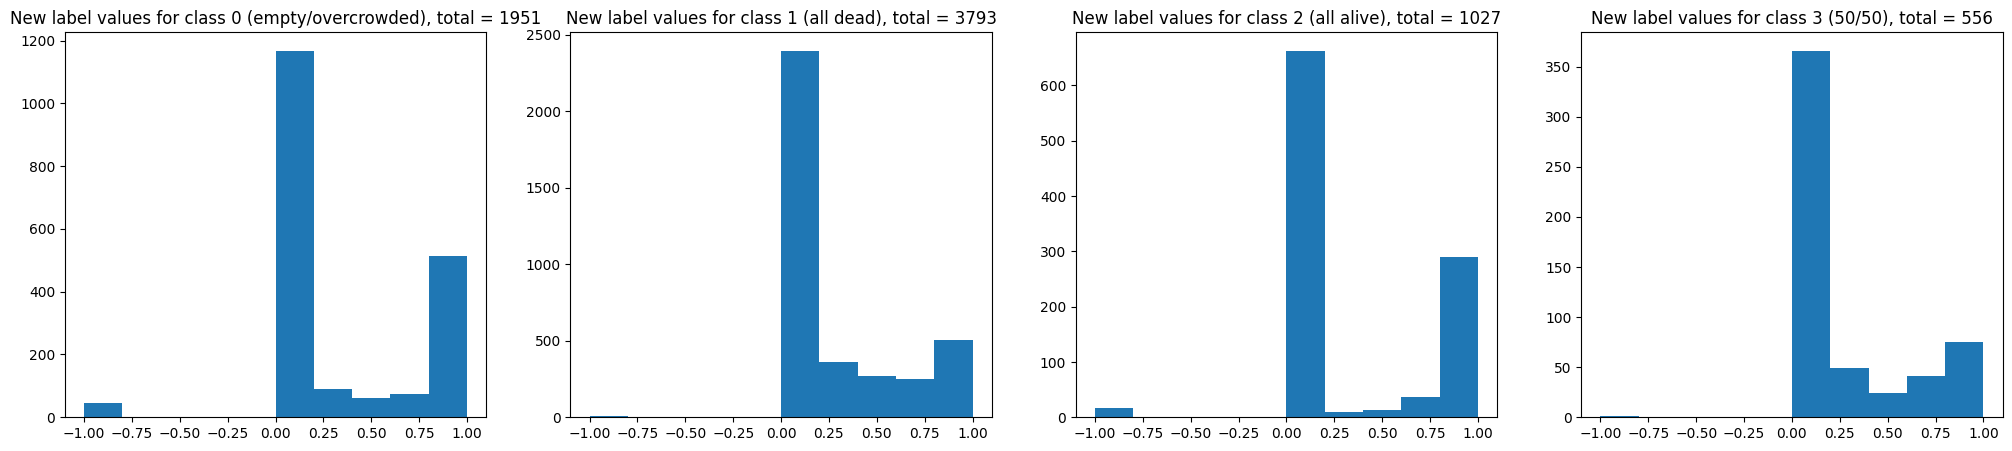

In [127]:
fig, ax = plt.subplots(1, len(labels_set), figsize=(25, 5))
for index, i in enumerate(labels_set):
    x = labels_df[labels_df['true_label'] == i]['new_label']
    ax[index].hist(x, bins=10)
    ax[index].set_title(f'New label values for class {i} ({LABEL_MAP[i]}), total = {len(x)}')

In [72]:
incorrect_1 = len(labels_df[(labels_df['true_label'] == 1) & (labels_df['new_label'] <= 0.5)])
all_1 = len(labels_df[labels_df['true_label'] == 1])
incorrect_2 = len(labels_df[(labels_df['true_label'] == 2) & (labels_df['new_label'] >= 0.5)])
all_2 = len(labels_df[labels_df['true_label'] == 2])
print(f'{round(incorrect_1 / all_1 * 100, 3)}% mismatches in class 1')
print(f'{round(incorrect_2 / all_2 * 100, 3)}% mismatches in class 2')

77.01% mismatches in class 1
32.814% mismatches in class 2


In [128]:
labels_df[labels_df['true_label'] == 0]

,true_label,new_label,idx
0,0,0.000000,0
9,0,0.000000,9
10,0,0.974359,10
21,0,-1.000000,21
24,0,1.000000,24
...,...,...,...
7322,0,1.000000,7322
7323,0,0.312500,7323
7324,0,0.250000,7324
7325,0,1.000000,7325


In [73]:
# labels_df[(labels_df['true_label'] == 2) & (labels_df['new_label'] > 0.75)]
labels_df[(labels_df['true_label'] == 1) & (labels_df['new_label'] < 0.25)]

,true_label,new_label,idx
12,1,0.083333,12
26,1,0.000000,26
37,1,0.000000,37
38,1,0.074627,38
39,1,0.035714,39
...,...,...,...
7263,1,-1.000000,7263
7273,1,-1.000000,7273
7306,1,-1.000000,7306
7310,1,0.200000,7310
